In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
def load_file(f):
    fixprice = lambda x: float(x.replace(',', '.'))
    df = pd.read_csv(f)
    if "Gmt time" in df.columns:
        df['Date'] = pd.to_datetime(df['Gmt time'], format="%d.%m.%Y %H:%M:%S.%f")
    elif "time" in df.columns:
        df['Date'] = pd.to_datetime(df['time'], unit="s")
        df['Date'] = df['Date'] + np.timedelta64(3 * 60, "m")
        df[['Date', 'Open', 'High', 'Low', 'Close']] = df[['Date', 'open', 'high', 'low', 'close']]
        df = df[['Date', 'Open', 'High', 'Low', 'Close']]
    elif "Tarih" in df.columns:
        df['Date'] = pd.to_datetime(df['Tarih'], format="%d.%m.%Y")
        df['Open'] = df['Açılış'].apply(fixprice)
        df['High'] = df['Yüksek'].apply(fixprice)
        df['Low'] = df['Düşük'].apply(fixprice)
        df['Close'] = df['Şimdi'].apply(fixprice)
    else:
        df["Date"] = pd.to_datetime(df["Date"])
    # we need to shift or we will have lookahead bias in code
    df["Returns"] = (df["Close"].shift(1) - df["Close"].shift(2)) / df["Close"].shift(2)
    return df

In [136]:
def plot_candles(df, l=0):
    """
        Plots candles
        l: plot last n candles. If set zero, draw all
    """
    db = df.copy()
    if l > 0:
        db = db[-l:]
    db = db.reset_index(drop=True).reset_index()
    db["Up"] = db["Close"] > db["Open"]
    db["Bottom"] = np.where(db["Up"], db["Open"], db["Close"])
    db["Bar"] = db["High"] - db["Low"]
    db["Body"] = abs(db["Close"] - db["Open"])
    db["Color"] = np.where(db["Up"], "g", "r")
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    ax.yaxis.tick_right()
    ax.bar(db["index"], bottom=db["Low"], height=db["Bar"], width=0.25, color="#000000")
    ax.bar(db["index"], bottom=db["Bottom"], height=db["Body"], width=0.5, color=db["Color"])
    ax.plot(db["OVB"], color="r", linewidth=0.25)
    ax.plot(db["OVS"], color="r", linewidth=0.25)
    plt.show()

In [137]:
def add_momentum(df, lb=20, std=2):
    df["MA"] = df["Returns"].rolling(lb).mean()
    df["STD"] = df["Returns"].rolling(lb).std()
    df["OVB"] = df["Close"].shift(1) * (1 + (df["MA"] + df["STD"] * std))
    df["OVS"] = df["Close"].shift(1) * (1 + (df["MA"] - df["STD"] * std))
    return df

In [138]:
def stats(df):
    total = len(df)
    ins1 = df[(df["Close"] > df["OVS"]) & (df["Close"] < df["OVB"])]
    ins2 = df[(df["Close"] > df["OVS"])]
    ins3 = df[(df["Close"] < df["OVB"])]
    il1 = len(ins1)
    il2 = len(ins2)
    il3 = len(ins3)
    r1 = np.round(il1 / total * 100, 2)
    r2 = np.round(il2 / total * 100, 2)
    r3 = np.round(il3 / total * 100, 2)
    return r1, r2, r3

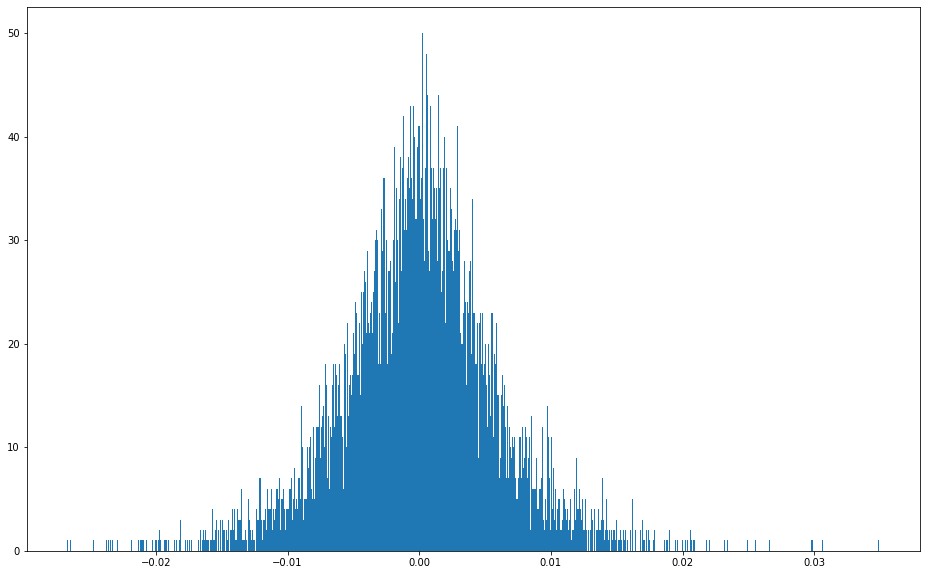

In [143]:
sym = "EURUSD"
period = "1d"
fl = "./{} {}.csv".format(period, sym)
df = load_file(fl)
df["Returns"].hist(bins=1000, grid=False, figsize=(16,10))

In [144]:
df = add_momentum(df, 20, 1)

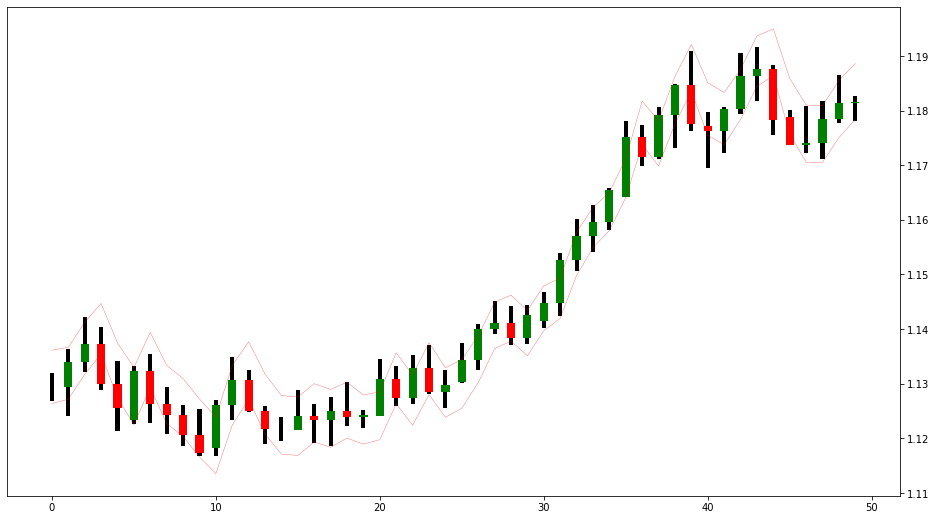

In [145]:
plot_candles(df, 50)

In [146]:
stats(df)

(67.36, 83.3, 83.77)